In [4]:
from songs import *

# НЕЙРОНКИ

In [5]:
import numpy as np
from numpy import random
import queue
import sys
from graphviz import Digraph

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
MEMORY_TIMES = 64  # сколько предыдущих моментов времени подаётся на вход
STARTER = 8        # сколько первых моментов времени берём для старта импровизации

ADDITIONAL_MEMORY = 8  # размер дополнительной памяти (в тек. версии - отметки о началах такта)

MEMORY_SIZE = MEMORY_TIMES * 13 + ADDITIONAL_MEMORY  # суммарный объём памяти

In [7]:
NOTE_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B", "C^"]

NAMES = []  # названия входов
for i in range(8):  # отметки о долях идут первыми
    NAMES.append("[tb" + str(i) + "]")
for t in range(-MEMORY_TIMES, 0):
    for note_name in NOTE_NAMES:
        NAMES.append(note_name + str(t))

In [46]:
class Edge:  # класс связи между нейронами
    def __init__(self, inp, outp, w, was_right=[1, 1], precedents=[1, 1]):
        self.input = inp
        self.output = outp
        self.weight = w
        
        # важные статистики: количество верных ответов вида -1 и 1, и число прецендентов.
        self.was_right = was_right[:]
        self.precedents = precedents[:]
        
    def quality(self):
        # статистика, соответствующая переданному сигналу (-1 или 1), и есть качество связи
        return self.was_right[self.input.emitted() == 1] / self.precedents[self.input.emitted() == 1]
    
    def op_quality(self):
        # статистика, соответствующая переданному сигналу (-1 или 1), и есть качество связи
        return self.was_right[self.input.emitted() != 1] / self.precedents[self.input.emitted() != 1]

class Neuron:
    def __init__(self, index, name="", was_one=1, used=2, is_base=False):
        self.name = name        # название для отображения в графе
        
        self.index = index      # номер соответствует индексу в массиве нейронов сети. Это защита от циклов.
        self.is_base = is_base  # пометка, что это вход или выход, и трогать его нельзя
        
        self.inputs = []        # список входов
        self.outputs = []       # список выходов
        self.signal = 0         # сумма текущих входов
        
        # важная статистика: как часто нейрон выдаёт 1
        self.was_one = was_one   # сколько раз сигнал равнялся 1
        self.used = used        # сколько раз вообще проводился запуск
        
        # переменная для хранения качества сигнала
        self.signal_quality = 1
        
        # равно true, если этот нейрон внёс вклад в правильный ответ на каком-то выходе в текущем запуске
        self.success = False
        
    # вспомогательные функции
    def emitted(self):
        # значение выхода по сумме входов - пороговая функция по нулю
        if self.signal > 0:
            return 1
        return -1    
    def getSureness(self):
        # сколько входов нужно инвертировать, чтобы получить другой ответ
        if self.signal > 0:
            return (self.signal + 1) // 2
        else:
            return 1 + (-self.signal) // 2
    def getError(self):
        # ошибка в количестве голосов
        if self.signal > 0:
            return self.signal
        else:
            return 1 - self.signal
        
    def initialize(self):
        # инициализация перед запуском
        self.signal = 0
        self.signal_quality = []
        self.success = False
    def emit(self, neurons):
        # функция "срабатывание" нейрона
        
        self.used += 1  # подсчёт статистик
        if self.signal > 0:
            self.was_one += 1
        
        sureness = self.getSureness()
            
        if len(self.signal_quality) == 0:
            self.signal_quality = 1
        else:
            self.signal_quality = sorted(self.signal_quality)[sureness - 1]
        
        for edge in self.outputs:  # перебор выходов
            edge.output.signal += edge.weight * self.emitted()  # добавление в сумму своего вклада
            
            # обновляем качество сигнала: оно равняется минимальному качеству входа, 
            # где качество входа - качество сигнала на входе * качество связи
            edge.output.signal_quality.append(edge.quality() * self.signal_quality)   
                
    def reward(self, true_val, error_proba=1):
        # оценивание связи по известному правильному ответу
        
        if self.emitted() == true_val:  # если выдал нужный сигнал, помечаем нейрон как "не трожь!"
            self.success = True
            
        sureness = self.getSureness()
                   
        for edge in self.inputs:
            input_val = edge.input.emitted()  # входной сигнал
            
            edge.precedents[input_val == 1] += 1 * error_proba
            if input_val * edge.weight == true_val:
                edge.was_right[input_val == 1] += 1 * error_proba

            edge.input.reward(true_val * edge.weight, error_proba / sureness)  # переходим во вход рекурсивно

In [65]:
class Func:
    def __init__(self):
        # нейроны-входы
        self.neurons = [Neuron(i, name=NAMES[i], was_one=0, used=1, is_base=True) for i in range(MEMORY_SIZE)]
        # нейроны-выходы
        for i in range(13):                                                                  
            self.neurons.append(Neuron(MEMORY_SIZE + i, name=NOTE_NAMES[i] + "outp", was_one=0, used=1, is_base=True)) 
        
        self.IDS = 0  # id нужны, чтобы различать нейроны, и давать имена скрытым нейронам.
        self.Random = np.random.RandomState(seed=179)  # рандом       
        self.verbose = False  # отладка
        self.level = 1
        
    def apply(self, x):  # проход по нейросети
        for neuron in self.neurons:
            neuron.initialize()
        
        # посылаем сигналы на нужные входы
        for i, val in enumerate(x):  
            if val == 1:
                self.neurons[i].signal += 1
        
        # запускаем нейроны
        for N in self.neurons:
            N.emit(self.neurons)
        
        # собираем включившиеся выходы
        return np.array([self.neurons[-13+i].emitted() == 1 for i in range(13)])
    
    def reward(self, true_vals):  # награждаем связи
        for i, val in enumerate(true_vals):
            if val == 1:
                self.neurons[-13+i].reward(1)
            else:
                self.neurons[-13+i].reward(-1)
            
    def forget_info(self):  # сбрасывание всех статистик - опциональная возможность. "Выучил выборку - пересчитай статистики".
        for N in self.neurons:
            for edge in N.inputs:
                edge.was_right = [1, 1]
                edge.precedents = [1, 1]
            
            if N.is_base:
                N.was_one = 0
                N.used = 1
            else:
                N.was_one = 1
                N.used = 2
    
    def randomOne(self, conseq):   # выбор случайного нейрона для создания гипотезы
        # гипотеза в данном контексте - это новая связь
        # гипотеза тем акутальнее, чем более специфично выбранное событие для текущей ситуации
        # то есть хочется выбрать гипотезу, которая срабатывает именно в этом запуске
        # для этого хочется взять событие, которое случилось в данном запуске, но его априорная вероятность очень мала
        # то есть выудить из текущего события какую-нибудь ценную информацию
        # поэтому вероятность выбора гипотезы пропорциональна 1 - P(события)
        
        candidates = []  # список нейронов-кандидатов
        proba = []       # список вероятностей, с котороыми мы их выберем
        
        # перебираем нейроны, стоящие в массиве до следствия, чтобы избежать циклов
        # также мы не берём выходы всей сети (последние 13 нейронов)
        for N in self.neurons[:min(len(self.neurons) - 13, conseq.index)]:
            # ВАЖНО! тут по идеи должна стоять защита от случая, 
            # что этот нейрон уже используется как вход для conseq. Однако...
            candidates.append(N) 
            
            # считаем вероятность
            if N.emitted() == 1:  
                proba.append(1 - N.was_one / N.used)
            else:
                proba.append(N.was_one / N.used)
        
        # делаем случайный выбор
        proba = np.array(proba)
        proba /= proba.sum()
        return self.Random.choice(candidates, p=proba)
    
    def connect(self, N1, N2, w, was_right=[1, 2], precedents=[2, 3]):
        # соединяем два нейрона новой связью; rewards-precedents это её исходная оценка
        if self.verbose:
            print("new edge (w=" + str(w) + ") between layers: ", N1.name, "(", N1.index, ")", " / ", N2.name, "(", N2.index, ")")
        NewEdge = Edge(N1, N2, w, was_right, precedents)
        N1.outputs.append(NewEdge)
        N2.inputs.append(NewEdge)
        return True
    
    def check_for_blow(self, neurons_queue):
        # нейрон отваливается, если у него нет входов или выходов
        # эта функция делает проверку очереди neurons_queue на такие нейроны
        # и уничтожает отвалившиеся
        
        while not neurons_queue.empty():
            N = neurons_queue.get()
            
            # проверяем нейрон; если у него нет входов или выходов, взрываем
            if N in self.neurons and not N.is_base: #возможно, он уже взорван
                if len(N.outputs) == 0:
                    if self.verbose:
                        print("neuron destroyed! ", N.name, "(", N.index, ")")
                    for edge in N.inputs[:]:
                        self.disconnect(edge, neurons_queue)
                elif len(N.inputs) == 0:
                    if self.verbose:
                        print("neuron destroyed! ", N.name, "(", N.index, ")")
                    for edge in N.outputs[:]:
                        self.disconnect(edge, neurons_queue)
                else:
                    continue
                
                # окончательное удаление из списка
                for neuron in self.neurons[N.index:]:
                    neuron.index -= 1
                self.neurons.remove(N)
                
    def disconnect(self, edge, neurons_queue=None):
        # разъединяем связь
        if self.verbose:
            print("remove edge between layers: ", edge.input.name, "(", edge.input.index, ")", " / ", edge.output.name, "(", edge.output.index, ")")
        edge.output.inputs.remove(edge)
        edge.input.outputs.remove(edge)
        
        # какие-то нейроны могли остаться без входов или выходов и их нужно взорвать: возвращаем очередь для проверки
        if neurons_queue is None:
            neurons_queue = queue.Queue()
        neurons_queue.put(edge.input)
        neurons_queue.put(edge.output)
        return neurons_queue
        
    def add_stub(self, edge):
        # добавление заглушки, т.е. нового нейрона в сеть
        # выбирается связь, по которой прошёл неверный сигнал, и разрывается нейроном
        # веса для двух новых связей выбираются так, чтобы произведение равнялось весу исходной связи
        # При этом варианта в любом случае два. Заведомо известно, что в стабе будет ошибка, 
        # а количество голосов будет -1 или 1 в зависимости от сигнала с единственного входа
        # Поскольку при 0 нейрон выдаёт -1, то проще 1 исправить в 0, чем -1 в 1
        # => выбираем тот вариант, при котором в стаб придёт сигнал 1
        
        # вычисление положения нейрона в сети. Он должен быть между входом и выходом разрываемой связи
        # и не задеть входной и выходной слой!
        stub_index = 1 + self.Random.randint(max(edge.input.index, MEMORY_SIZE - 1), min(len(self.neurons) - 13, edge.output.index))
        
        # Вообще-то, тут можно ещё вычислить априорную вероятность 1 для нового нейрона (соотв. вероятности единственного входа)
        # ну пока этого нет
        
        # добавление нейрона
        stub = Neuron(stub_index, name=str(self.IDS))
        self.IDS += 1
        
        for neuron in self.neurons[stub_index:]:  # индекс последующих нейронов смещается на единицу
            neuron.index += 1
        self.neurons.insert(stub_index, stub)
        
        stub.signal = 1  # заполняем параметры текущего запуска для корректной работы
        stub.signal_quality = edge.input.signal_quality * edge.quality()
        
        if self.verbose:
            print("created stub (", stub_index, ") between: ", edge.input.name, "(", edge.input.index, ")", " / ", edge.output.name, "(", edge.output.index, ")")
        
        # решение уравнения на новые два веса: сигнал со входа; сигнал со входа на исходный вес.
        # при перемножении дадут исходный вес; в стаб придёт 1
        
        # изначальные оценки связей берём из разорванной связи?
        inp_signal = edge.input.emitted()
        self.connect(edge.input, stub, inp_signal)#, edge.was_right, edge.precedents)
        self.connect(stub, edge.output, inp_signal * edge.weight)#, edge.was_right, edge.precedents)
        self.disconnect(edge)
        
        return stub
        
    def turn(self, EndNeuron, wish):
        # АЛГОРИТМ ПОПРАВКИ!        
        operations = []
        operands = []
        wishes = []
        operation_proba = np.array([])
        
        candidates = []
        candidates_wishes = []
        
        BeginNeuron = EndNeuron
        current_wish = wish
        error_proba = 1
        while not BeginNeuron.success and BeginNeuron.index >= MEMORY_SIZE:            
            #operations.append("AddEdge")
            #operands.append(BeginNeuron)
            #wishes.append(current_wish)
            #operation_proba = np.append(operation_proba, error_proba * 2 / BeginNeuron.getError())
            candidates.append(BeginNeuron)
            candidates_wishes.append(current_wish)
            
            paths = []
            paths_proba = []
            for edge in BeginNeuron.inputs:
                    if edge.input.emitted() * edge.weight != current_wish:
                        paths.append(edge)
                        paths_proba.append(1 - edge.quality() * edge.input.signal_quality)
            
            if len(paths) > 0:
                paths_proba = np.array(paths_proba)
                #paths_proba /= paths_proba.sum()
                #c = self.Random.choice(np.arange(len(paths)), p=paths_proba)
                c = paths_proba.argmax()
                chosen_edge = paths[c]
                
                if chosen_edge.quality() < 0.5:
                    if self.Random.uniform(0, 1) < (1 - chosen_edge.quality())**self.level:
                        self.check_for_blow(self.disconnect(chosen_edge))
                        return
                
                operation_proba *= chosen_edge.quality()
                
                operations.append("Stub")
                operands.append(chosen_edge)
                wishes.append(current_wish)
                operation_proba = np.append(operation_proba, chosen_edge.quality() * error_proba)
                               
                BeginNeuron = chosen_edge.input
                current_wish *= chosen_edge.weight
                error_proba *= chosen_edge.op_quality()                
            else:
                break
                
        for w, N in zip(candidates_wishes[::-1], candidates[::-1]):
            if N.getError() == 1:
                one = self.randomOne(N)
                self.connect(one, N, w * one.emitted())
                return
            
        if self.verbose:
            print([(op, p) for op, p in zip(operations, operation_proba)])
            
        operation_proba = np.exp(operation_proba)
        operation_proba /= operation_proba.sum()
        
        if self.verbose:
            print([(op, p) for op, p in zip(operations, operation_proba)])
            
        index = operation_proba.argmax()#self.Random.choice(np.arange(len(operations)), p=operation_proba)
        operation = operations[index]
        operand = operands[index]
        wish = wishes[index]
        
        if operation == "Stub":
            # Ошибка со связью. Строим стаб.
            stub = self.add_stub(operand)
            
            one = self.randomOne(stub)
            self.connect(one, stub, -one.emitted())
        #elif operation == "Delete":
        #    self.check_for_blow(self.disconnect(operand))
        #elif operation == "AddEdge":
        #    one = self.randomOne(operand)
        #    self.connect(one, operand, wish * one.emitted())
        else:
            print("wtf")
    
    def draw(self):
        # рисуем нейросеть
        dot = Digraph(format='png')
        for N in self.neurons:
            if N.index < MEMORY_SIZE:
                dot.attr('node', shape='doublecircle')
            elif N.is_base:
                dot.attr('node', shape='circle', color='green')
            else:
                dot.attr('node', style='filled', color='lightblue')
                
            if len(N.outputs) > 0 or len(N.inputs) > 0:
                dot.node(label = N.name + "\nq={0:.2f},".format(N.signal_quality) + "\ne={0:.3f}".format(N.was_one / N.used), 
                         name = N.name, size='2')
        
        for N in self.neurons:
            for edge in N.inputs:
                c = "blue"
                if edge.weight == -1:
                    c = "red"
                dot.edge(edge.input.name, edge.output.name, color = c, 
                         label = "{0:.2f}".format(edge.was_right[0] / edge.precedents[0]) + 
                           "/" + "{0:.2f}".format(edge.was_right[1] / edge.precedents[1]))
        #dot.render(view=True)
        return dot

In [66]:
class Player:
    def __init__(self):
        self.play_note = Func()
           
    def learn_to_play(self, song_to_learn, verbose=False, learn=True, limit = -1):
        if limit == -1:
            limit = len(song_to_learn.notes)
        self.play_note.verbose = verbose
        
        # исходная память
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = song_to_learn.notes[:STARTER].flatten()

        t = STARTER
        memory[t % 8] = 1
        
        # считаем ошибки
        errors = 0
        
        while t < limit:    
            # играем
            output = self.play_note.apply(memory)
            # награждаем связи
            self.play_note.reward(song_to_learn.notes[t])
            
            if verbose:
                print(output.astype(int))
            
            # ищем ошибки
            for note in range(13):    
                if output[note] != song_to_learn.notes[t][note]:
                    errors += 1
                    if learn:  # дообучаемся: говорим исправиться на этом входе
                        if output[note] == 0:
                            self.play_note.turn(self.play_note.neurons[-13 + note], 1)
                        else:
                            self.play_note.turn(self.play_note.neurons[-13 + note], -1)
                    #return t
            
            # переходим к следующей итерации
            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], song_to_learn.notes[t]])
            t += 1
            memory[t % 8] = 1
            
        return errors
    
    def improvise(self, starter, length=128):  # играет чё хочет
        memory = np.zeros((MEMORY_SIZE), dtype=int)
        memory[-STARTER*13:] = starter.notes[:STARTER].flatten()

        result = MySong(starter.notes[:STARTER])
        
        t = STARTER
        memory[t % 8] = 1
        while t < length:    
            output = self.play_note.apply(memory)
            result.add(output)

            memory = np.concatenate([np.zeros((ADDITIONAL_MEMORY)), memory[ADDITIONAL_MEMORY + 13:], output])
            t += 1
            memory[t % 8] = 1
        result.finish()
        
        return result

## Обучение

Создаём нового игрока и грузим пока кузнечика

In [67]:
player = Player()

In [68]:
kuznechik = Song('../basic midi/track (1).mid')

In [69]:
player.learn_to_play(kuznechik, verbose=True, limit=128)

[0 0 0 0 0 0 0 0 0 0 0 0 0]
new edge (w=1) between layers:  E-2 ( 818 )  /  Aoutp ( 849 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
new edge (w=-1) between layers:  A-9 ( 732 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 1 0 0 0 0]
new edge (w=-1) between layers:  A-3 ( 810 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0]
remove edge between layers:  A-9 ( 732 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 1 0 0 0 0]
remove edge between layers:  A-3 ( 810 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
new edge (w=-1) between layers:  E-4 ( 792 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 1 0 0 0 0]
remove edge between layers:  E-4 ( 792 )  /  G#outp ( 848 )
[0 0 0 0 0 0 0 0 0 0 0 0 0]
new edge (w=-1) between layers:  G#-4 ( 796 )  /  Eoutp ( 844 )
[0 0 0 0 1 0 0 0 0 0 0 0 0]
new edge (w=-1) between layers:  G#-7 ( 757 )  /  Eoutp ( 844 )
[0 0 0 0 0 0 0 0 0 1 0 0 0]
new edge (w=1) between layers:  G#-8 ( 744 )  /  G#outp ( 848 )
new edge (

86

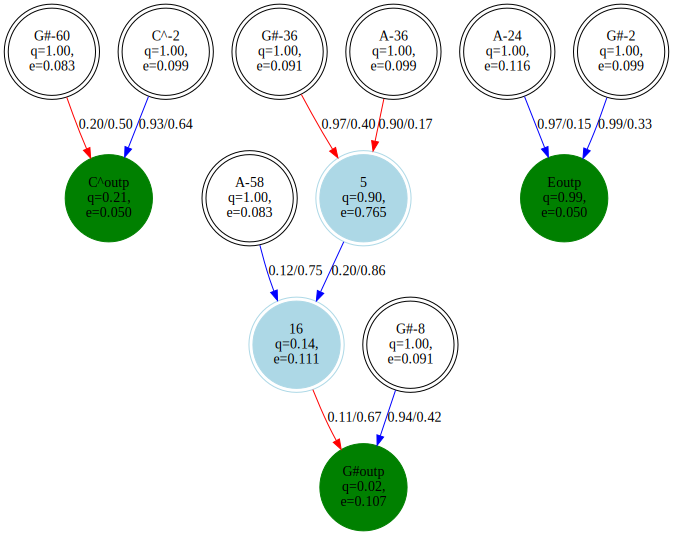

In [70]:
player.play_note.draw()

In [84]:
player.play_note.draw().render("Адаптивно забывающий слон запомнил кузнечика (45 скрытых нейронов, финальный уровень 6,5)")

'Адаптивно забывающий слон запомнил кузнечика (45 скрытых нейронов, финальный уровень 6,5).png'

In [85]:
len(player.play_note.neurons[-4].inputs)

25

# Random Path Suicide Elephant with deleting on bad p

Random Path БЕЗ действия "удалить". Все вероятности выбора действия считаются как произведения соотв. edge_quality, затем выбираем случайно с весами из вероятностей.
При ВСТРЕЧЕ (в поиске пути) ребра с качеством ниже 0.5 это ребро удаляется с вероятностью 1 - (1 - EQ)**4. 


## Результаты:
до 73 за 930 нейронов окей. Чуть застрявает на 87; нейронов становится от этого много, под тысячу. Затем застрявает на 93 и умирает. Связи скапливаются на выходах.

## МОДЫ:
берём жёстко самое крутое действие. Ого чо происходит, взмывает на 853 нейронах до 93... чё за фигня творится?!?!? без нейронов до 97 дошёл, ерунда какая-то... Не, до 101... Бред какой-то, он чо, линейно всё сейчас запомнит?.. Офигеть, но да. Позже: да, вышло неудачно, на первых итерациях крутость действий "создать нейрон" и "создать связь" одинакова, выбирается второе, и новые нейроны не появляются.

Итак, задача всё это время была линейно разделима... супер! 

Домножим вероятность создания связи на 2 / error в нейроне. Нейроны появились =) Взлетает до 93 с 925 нейронами, там... проходит, довольно быстро, но клепает ещё сотню. Однако, сходится. 1081 нейрон...

^3 вместо ^4. Подзастрял на 87-ом, получив +100 нейронов, до этого было окей. 1068 нейронов...

## Random Path Suicide Elephant with deleting on bad p and reverse edge adding

оставляем ТОЛЬКО стабы. Проходим по пути "назад", удаляя. Проходим по пути "вперёд", добавляя, где error = 1. Если ничего не сделали, стаб. Шикарно идёт до 85 и умирает.

двигаемся не только по edge_quality при выборе пути, но и домножаем (!) на signal_quality. Ситуацию не изменило.

^4 вместо ^3 делает только хуже

выбираем ХУДШИЙ путь. Прорывается с трудом через 85, но с хорошим числом нейронов.

## Random Path Suicide Elephant with deleting on bad p and reverse edge adding ADAPTIVE LEVEL

Циферку делаем переменной и меняем по ходу обучения. Пока схема такая: ошибок на эпохе больше, чем раньше - увеличиваем на 0.1, ошибок меньше - уменьшаем на 0.1

Итог: СОШЛОСЬ, 890 нейронов. Конечный уровень - 6,5! Базовая процедура: сошлась. Конечный итог - 907 нейронов, но уровень 11,1

In [80]:
player = Player()

In [81]:
def stubs_input(F):
    return np.array([len(N.inputs) for N in F.neurons[MEMORY_SIZE:-13]]).mean()
def stubs_output(F):
    return np.array([len(N.outputs) for N in F.neurons[MEMORY_SIZE:-13]]).mean()

In [82]:
limit = 8
neurons = [MEMORY_SIZE + 13]
stubs_outputs = [0]
stubs_inputs = [0]

while limit <= 128:#len(kuznechik.notes):
    print("limit: ", limit, " neurons_at_start: ", len(player.play_note.neurons), " level: ", player.play_note.level)
    errors = [kuznechik.notes[:limit].sum()]
    while errors[-1] > 0:
        errors.append(player.learn_to_play(kuznechik, limit=limit))
        if errors[-1] >= errors[-2]:
            player.play_note.level += 0.1
        else:
            player.play_note.level -= 0.1
        
        neurons.append(len(player.play_note.neurons))
        stubs_outputs.append(stubs_output(player.play_note))
        stubs_inputs.append(stubs_input(player.play_note))
               
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    limit += 1

limit:  8  neurons_at_start:  853  level:  1
0 
limit:  9  neurons_at_start:  853  level:  0.9
1 0 
limit:  10  neurons_at_start:  853  level:  0.7000000000000001
0 
limit:  11  neurons_at_start:  853  level:  0.6000000000000001
1 2 2 2 1 0 
limit:  12  neurons_at_start:  853  level:  0.6000000000000001
0 
limit:  13  neurons_at_start:  853  level:  0.5000000000000001
1 2 0 
limit:  14  neurons_at_start:  853  level:  0.40000000000000013
0 
limit:  15  neurons_at_start:  853  level:  0.30000000000000016
1 3 2 0 
limit:  16  neurons_at_start:  854  level:  0.10000000000000014
0 
limit:  17  neurons_at_start:  854  level:  1.3877787807814457e-16
1 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  


0 
limit:  18  neurons_at_start:  855  level:  -0.19999999999999987
0 
limit:  19  neurons_at_start:  855  level:  -0.2999999999999999
1 2 2 2 2 2 0 
limit:  20  neurons_at_start:  855  level:  8.326672684688674e-17
0 
limit:  21  neurons_at_start:  855  level:  -0.09999999999999992
2 0 
limit:  22  neurons_at_start:  856  level:  -0.29999999999999993
0 
limit:  23  neurons_at_start:  856  level:  -0.3999999999999999
2 2 3 4 3 3 3 3 2 2 4 2 2 3 3 2 2 2 2 2 1 2 3 0 
limit:  24  neurons_at_start:  857  level:  0.6000000000000001
0 
limit:  25  neurons_at_start:  857  level:  0.5000000000000001
1 1 0 
limit:  26  neurons_at_start:  859  level:  0.40000000000000013
0 
limit:  27  neurons_at_start:  859  level:  0.30000000000000016
2 2 2 2 2 2 2 2 2 3 2 1 0 
limit:  28  neurons_at_start:  861  level:  0.8
0 
limit:  29  neurons_at_start:  861  level:  0.7000000000000001
2 4 6 5 4 6 6 7 6 6 10 8 4 5 3 4 4 6 4 4 6 5 4 5 4 4 4 7 3 8 2 2 6 4 4 6 4 2 3 2 1 1 0 
limit:  30  neurons_at_start:  862

2 3 3 3 2 3 4 1 0 
limit:  100  neurons_at_start:  895  level:  8.499999999999988
0 
limit:  101  neurons_at_start:  895  level:  8.399999999999988
0 
limit:  102  neurons_at_start:  895  level:  8.299999999999988
1 2 1 0 
limit:  103  neurons_at_start:  895  level:  8.099999999999989
1 4 3 3 0 
limit:  104  neurons_at_start:  896  level:  7.999999999999989
1 5 5 0 
limit:  105  neurons_at_start:  897  level:  7.999999999999989
0 
limit:  106  neurons_at_start:  897  level:  7.89999999999999
0 
limit:  107  neurons_at_start:  897  level:  7.79999999999999
0 
limit:  108  neurons_at_start:  897  level:  7.69999999999999
0 
limit:  109  neurons_at_start:  897  level:  7.599999999999991
0 
limit:  110  neurons_at_start:  897  level:  7.499999999999991
0 
limit:  111  neurons_at_start:  897  level:  7.3999999999999915
0 
limit:  112  neurons_at_start:  897  level:  7.299999999999992
0 
limit:  113  neurons_at_start:  897  level:  7.199999999999992
0 
limit:  114  neurons_at_start:  897  le

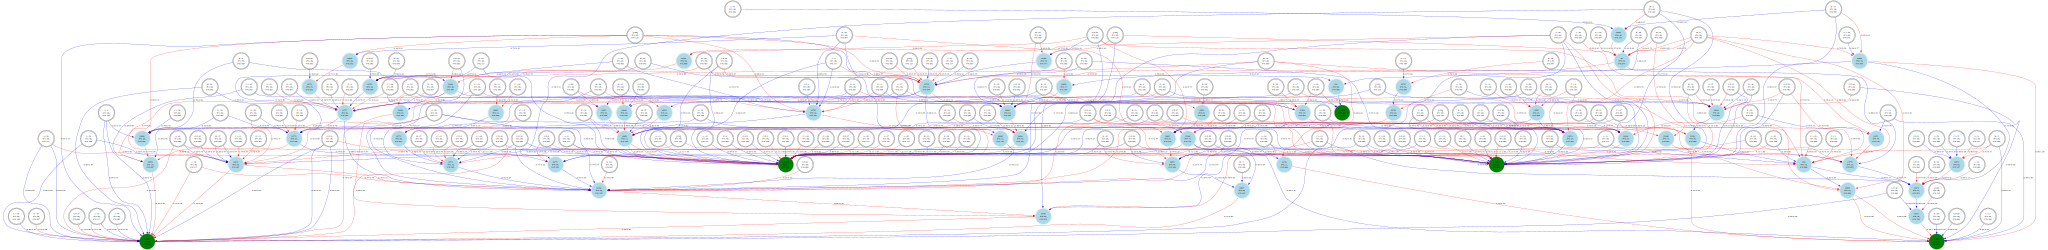

In [98]:
player.play_note.draw()

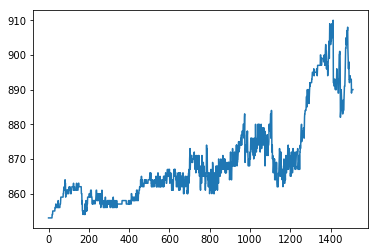

In [86]:
plt.plot(neurons)  # график количества нейронов в эпоху

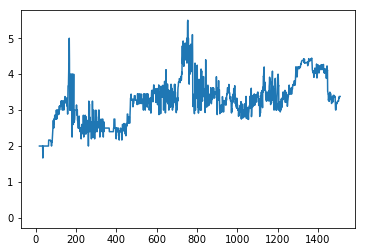

In [87]:
plt.plot(stubs_inputs)  # график количества нейронов в эпоху

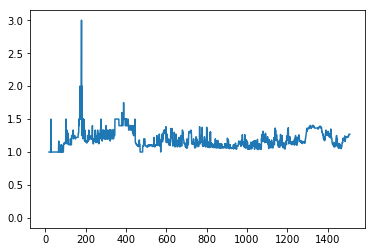

In [88]:
plt.plot(stubs_outputs)  # график количества нейронов в эпоху

# Базовый вариант

In [93]:
player = Player()

In [94]:
errors = [kuznechik.notes.sum()]
neurons = [MEMORY_SIZE + 13]
stubs_outputs = [0]
stubs_inputs = [0]

while errors[-1] > 0:
    errors.append(player.learn_to_play(kuznechik))
    if errors[-1] >= errors[-2]:
        player.play_note.level += 0.1
    else:
        player.play_note.level -= 0.1
    
    neurons.append(len(player.play_note.neurons))
    stubs_outputs.append(stubs_output(player.play_note))
    stubs_inputs.append(stubs_input(player.play_note))
    print(errors[-1], end=" ")
    sys.stdout.flush()
    
    #if errors[-1] > errors[-2]:
    #    player.play_note.learning_rate += 1

86 77 74 64 68 60 86 82 73 43 50 56 68 66 49 65 56 40 54 55 68 60 49 52 45 46 56 58 55 70 54 43 42 40 47 48 56 49 62 63 57 47 58 47 40 45 42 57 55 39 39 43 40 47 52 47 45 45 52 44 46 44 48 49 46 60 63 55 50 38 56 62 47 62 67 68 65 64 51 72 64 63 60 49 57 82 63 58 57 55 62 54 58 65 69 68 51 54 44 62 66 57 63 59 51 51 56 66 59 46 66 53 38 33 35 29 30 38 51 53 42 44 41 44 50 75 53 54 51 43 54 57 34 42 46 53 50 49 49 58 65 63 56 60 52 49 47 44 44 53 42 52 46 53 62 62 52 41 63 53 50 53 45 38 48 49 54 43 40 55 38 30 49 51 47 43 63 49 50 52 63 47 70 49 44 48 63 61 58 58 61 60 59 55 51 47 54 49 42 55 46 57 48 61 57 49 42 33 32 38 39 37 36 34 40 52 44 32 36 42 48 51 47 42 46 54 56 46 56 59 47 69 45 56 56 53 56 62 55 68 61 58 50 50 51 59 50 64 60 60 66 70 56 58 48 50 46 51 56 42 47 53 55 50 58 44 42 63 58 61 64 58 46 45 62 63 66 49 66 43 39 45 51 43 41 56 55 48 53 34 41 55 41 38 29 38 32 37 50 40 54 37 31 35 38 39 51 45 44 37 46 58 48 55 57 61 40 45 60 48 49 55 58 62 67 61 51 53 62 49 40 47 50 5

In [97]:
player.play_note.level

11.099999999999978

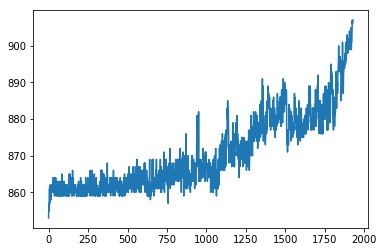

In [95]:
plt.plot(neurons)  # график количества нейронов в эпоху

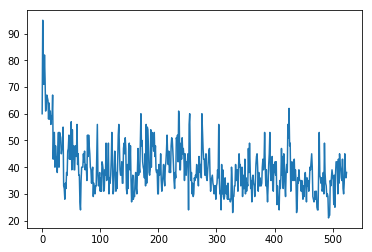

In [27]:
plt.plot(errors)  # график количества ошибок в эпоху

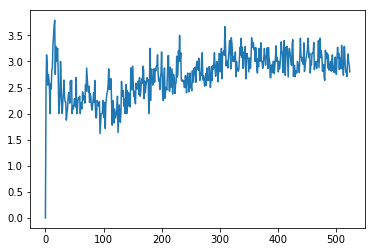

In [28]:
plt.plot(stubs_inputs)  # график количества нейронов в эпоху

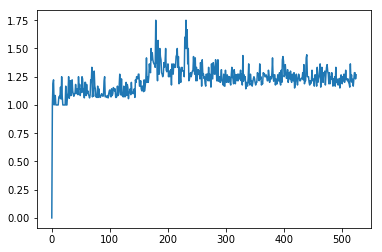

In [29]:
plt.plot(stubs_outputs)  # график количества нейронов в эпоху

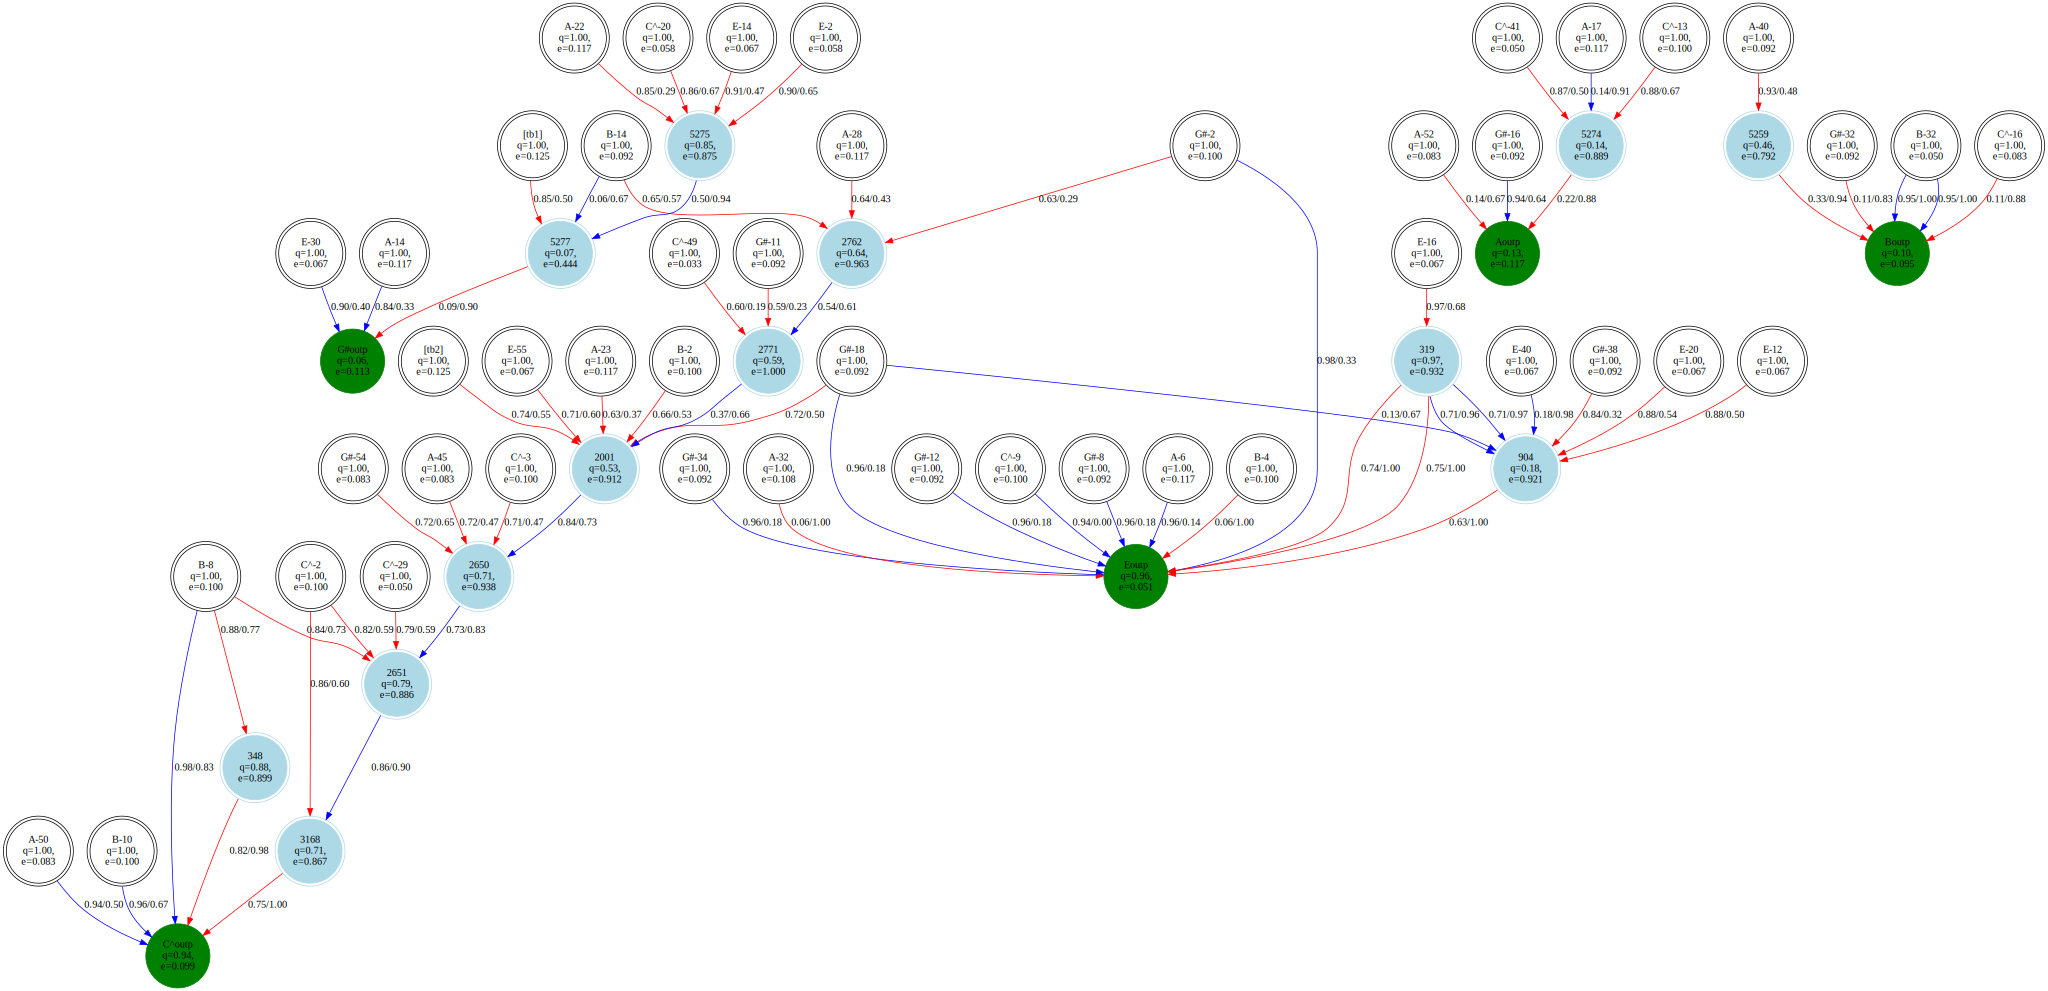

In [30]:
player.play_note.draw()

In [137]:
#player.play_note.draw().render('Бинарный слон') 

'Бинарный слон.png'

In [357]:
len(player.play_note.neurons)

947

Проверим, что всё окей. Подадим на вход начало кузнечика, а дальше пусть играет сам (память занимается тем, что игрок сам нажимает на рояле). Поскольку так заданы правила, кузнечик будет воспроизведён точно

In [89]:
player.improvise(kuznechik).play()

Окей, чтобы услышать что-то новое, нужно другое начало. Возьмём его из другой песенки

In [90]:
simple_song = Song([12, -1, 11, -1, 9, -1, 8, -1])
result = player.improvise(simple_song)
result.play()

In [91]:
simple_song = Song('../basic midi/track (2).mid')
result = player.improvise(simple_song)

Первый шедевр:

In [92]:
result.play()

## МНОГО ПЕСЕН

Игрок пока использует только несколько нот. Просто в кузнечике есть не все 13 нот, так что мы можем его посмещать, чтобы получить новую информацию. Попробуем сместить кузнечика на одну ноту

In [99]:
def addAllTransposedVersions(Songs, song):
    while song.transpose(1):
        pass

    Songs.append(copy.deepcopy(song))
    while song.transpose(-1):
        Songs.append(copy.deepcopy(song))

In [100]:
Songs = []
for i in range(1, 10):
    addAllTransposedVersions(Songs, Song('../basic midi/track (' + str(i) + ').mid'))

In [121]:
player = Player()

In [122]:
import random
random.shuffle(Songs)

prev_errors = np.array([Songs[i].notes.sum() for i in range(len(Songs))])
neurons = [len(player.play_note.neurons)]
levels = [player.play_note.level]

In [ ]:
while prev_errors.sum() > 10:
    errors = []
    for i, song in enumerate(Songs):
        errors.append(player.learn_to_play(song))
        
        if errors[-1] >= prev_errors[i]:
            player.play_note.level += 0.1
        else:
            player.play_note.level -= 0.05            
        
        neurons.append(len(player.play_note.neurons))
        levels.append(player.play_note.level)
        print(errors[-1], end=" ")
        sys.stdout.flush()
    print("")
    
    prev_errors = np.array(errors)
    print("sum = ", prev_errors.sum(), " level = ", levels[-1], " neurons = ", neurons[-1])

82 72 95 91 63 77 88 74 77 56 83 90 56 74 60 90 53 76 65 86 59 65 82 
sum =  1714  level =  3.300000000000002  neurons =  866
83 71 68 80 60 77 81 70 79 74 90 82 38 74 69 81 77 77 86 77 72 68 87 
sum =  1721  level =  4.100000000000004  neurons =  877
91 73 78 95 52 82 91 83 90 89 91 82 58 82 80 86 87 92 78 86 74 59 85 
sum =  1864  level =  5.799999999999998  neurons =  879
95 73 72 112 54 100 83 75 102 77 94 103 74 73 67 91 78 93 76 100 62 84 81 
sum =  1919  level =  6.599999999999995  neurons =  889
85 72 74 71 75 107 81 83 88 87 83 102 66 77 69 95 63 78 76 113 70 71 106 
sum =  1892  level =  7.249999999999993  neurons =  884
90 88 71 104 53 79 80 66 75 71 119 90 71 88 71 85 72 77 71 105 66 76 74 
sum =  1842  level =  7.449999999999992  neurons =  883
76 73 84 80 42 82 83 86 86 75 71 91 74 68 78 85 94 91 66 94 65 82 100 
sum =  1826  level =  8.399999999999986  neurons =  903
94 94 85 106 70 120 94 96 80 76 91 78 62 76 81 108 75 80 76 86 75 86 84 
sum =  1973  level =  9.64999999

In [373]:
len(player.play_note.neurons)

1134

In [196]:
simple_song = Song('../basic midi/whomadethis.mid')
result = player.improvise(simple_song)
result.play()

KeyboardInterrupt: 

In [143]:
result.save_file("181. Binary Elephant NN learned kuznechik (94 hidden neurons)")

In [144]:
simple_song = Song([0, -1, 5, -1, 4, -1, 5, -1])
result = player.improvise(simple_song)
result.play()

In [145]:
simple_song = Song([0, -1, 5, -1, 4, -1, 7, -1])
result = player.improvise(simple_song)
result.play()